# Netbacks Arb Delta

This script allows you to plot the Historical Evolution of Arbitrage Prices for a specific month.

This script uses elements from our API code samples. If you'd like a more basic and informative example of how to pull data via the Spark API, please visit our Github or API website:

- Github: https://github.com/spark-commodities/api-code-samples/blob/master/jupyter_notebooks/
- API Website: https://www.sparkcommodities.com/api/code-examples/jupyter.html


### Have any questions?

If you have any questions regarding our API, or need help accessing specific datasets, please contact us at:

__data@sparkcommodities.com__

or refer to our API website for more information about this endpoint:
https://www.sparkcommodities.com/api/request/netbacks.html

__N.B. This script requires a Cargo subscription__

## 1. Importing Data

Here we define the functions that allow us to retrieve the valid credentials to access the Spark API.

This section can remain unchanged for most Spark API users.

In [37]:
import json
import os
import sys
import numpy as np
from base64 import b64encode
from pprint import pprint
from urllib.parse import urljoin
import pandas as pd


try:
    from urllib import request, parse
    from urllib.error import HTTPError
except ImportError:
    raise RuntimeError("Python 3 required")


API_BASE_URL = "https://api.sparkcommodities.com"


def retrieve_credentials(file_path=None):
    """
    Find credentials either by reading the client_credentials file or reading
    environment variables
    """
    if file_path is None:

        client_id = os.getenv("SPARK_CLIENT_ID")
        client_secret = os.getenv("SPARK_CLIENT_SECRET")
        if not client_id or not client_secret:
            raise RuntimeError(
                "SPARK_CLIENT_ID and SPARK_CLIENT_SECRET environment vars required"
            )
    else:
        # Parse the file
        if not os.path.isfile(file_path):
            raise RuntimeError("The file {} doesn't exist".format(file_path))

        with open(file_path) as fp:
            lines = [l.replace("\n", "") for l in fp.readlines()]

        if lines[0] in ("clientId,clientSecret", "client_id,client_secret"):
            client_id, client_secret = lines[1].split(",")
        else:
            print("First line read: '{}'".format(lines[0]))
            raise RuntimeError(
                "The specified file {} doesn't look like to be a Spark API client "
                "credentials file".format(file_path)
            )

    print(">>>> Found credentials!")
    print(
        ">>>> Client_id={}, client_secret={}****".format(client_id, client_secret[:5])
    )

    return client_id, client_secret


def do_api_post_query(uri, body, headers):
    url = urljoin(API_BASE_URL, uri)

    data = json.dumps(body).encode("utf-8")

    # HTTP POST request
    req = request.Request(url, data=data, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 201, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def do_api_get_query(uri, access_token):
    url = urljoin(API_BASE_URL, uri)

    headers = {
        "Authorization": "Bearer {}".format(access_token),
        "Accept": "application/json",
    }

    # HTTP POST request
    req = request.Request(url, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 200, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def get_access_token(client_id, client_secret):
    """
    Get a new access_token. Access tokens are the thing that applications use to make
    API requests. Access tokens must be kept confidential in storage.

    # Procedure:

    Do a POST query with `grantType` and `scopes` in the body. A basic authorization
    HTTP header is required. The "Basic" HTTP authentication scheme is defined in
    RFC 7617, which transmits credentials as `clientId:clientSecret` pairs, encoded
    using base64.
    """

    # Note: for the sake of this example, we choose to use the Python urllib from the
    # standard lib. One should consider using https://requests.readthedocs.io/

    payload = "{}:{}".format(client_id, client_secret).encode()
    headers = {
        "Authorization": b64encode(payload).decode(),
        "Accept": "application/json",
        "Content-Type": "application/json",
    }
    body = {
        "grantType": "clientCredentials",
        "scopes": "read:netbacks,read:access,read:prices,read:routes"
    }

    content = do_api_post_query(uri="/oauth/token/", body=body, headers=headers)

    print(
        ">>>> Successfully fetched an access token {}****, valid {} seconds.".format(
            content["accessToken"][:5], content["expiresIn"]
        )
    )

    return content["accessToken"]


def list_netbacks(access_token):
    """
    Fetch available routes. Return contract ticker symbols

    # Procedure:

    Do a GET query to /v1.0/routes/ with a Bearer token authorization HTTP header.
    """
    content = do_api_get_query(uri="/v1.0/netbacks/reference-data/", access_token=access_token)

    print(">>>> All the routes you can fetch")
    tickers = []
    fobPort_names = []

    availablevia = []
    #reldates = []
    
    #availablevia = np.empty(shape=(len(content["data"]['staticData']['fobPorts'])))
    #reldates = np.empty(shape=(len(content["data"]['staticData']['fobPorts'])))
    
    #c = 0
    for contract in content["data"]['staticData']['fobPorts']:
        
        #print(contract)
        #print(contract["uuid"])
        tickers.append(contract["uuid"])
        fobPort_names.append(contract['name'])
        
        availablevia.append(contract['availableViaPoints'])
    
    reldates = content["data"]['staticData']['sparkReleases']
        
        #availablevia[c] = contract['availableViaPoints']
        #reldates[c] = contract["sparkReleases"]
        
        #c += 1

    #print(len(content))
    #print(content["data"]['routes'][0])
    #print(content["data"]['sparkReleaseDates'])
    
    #reldates = content["data"]['sparkReleaseDates']
    
    dicto1 = content["data"]
        
    return tickers, fobPort_names, availablevia, reldates, dicto1
    #return dicto1


### N.B. Credentials

N.B. You must have downloaded your client credentials CSV file before proceeding. Please refer to the API documentation if you have not dowloaded them already. Instructions for downloading your credentials can be found here:

https://www.sparkcommodities.com/api/request/authentication.html


In [38]:
client_id, client_secret = retrieve_credentials(
    file_path="/tmp/client_credentials.csv"
)

# Authenticate:
access_token = get_access_token(client_id, client_secret)

# Fetch all contracts:
tickers, fobPort_names, availablevia, reldates, dicto1 = list_netbacks(access_token)


>>>> Found credentials!
>>>> Client_id=875f483b-19de-421a-8e9b-dceff6703e83, client_secret=6cdf8****
>>>> Successfully fetched an access token eyJhb****, valid 604799 seconds.
>>>> All the routes you can fetch


### Data Import Base Functions

In [39]:
## Defining the function to fetch the data

def fetch_netback(access_token, ticker, release, via=None, laden=None, ballast=None):
    """
    For a route, fetch then display the route details

    # Procedure:

    Do GET queries to https://api.sparkcommodities.com/v1.0/routes/{route_uuid}/
    with a Bearer token authorization HTTP header.
    """
    
    query_params = "?fob-port={}".format(ticker)
    if release is not None:
        query_params += "&release-date={}".format(release)
    if via is not None:
        query_params += "&via-point={}".format(via)
    if laden is not None:
        query_params += "&laden-congestion-days={}".format(laden)
    if ballast is not None:
        query_params += "&ballast-congestion-days={}".format(ballast)

    
    content = do_api_get_query(
        uri="/v1.0/netbacks/{}".format(query_params),
        access_token=access_token,
    )
    
    my_dict = content['data']

    return my_dict


# Define formatting data function

def format_store(available_via, fob_names, tickrs):
    dict_store = {
        "Index": [],
        "Callable Ports": [],
        "Corresponding Ticker": [],
        "Available Via": []
    }
    
    c = 0
    for a in available_via:
        ## Check which routes have non-empty Netbacks data and save indices
        if len(a) != 0:
            dict_store['Index'].append(c)

            # Use these indices to retrive the corresponding Netbacks info
            dict_store['Callable Ports'].append(fob_names[c])
            dict_store['Corresponding Ticker'].append(tickrs[c])
            dict_store['Available Via'].append(available_via[c])
        c += 1
    # Show available Netbacks ports in a DataFrame (with corresponding indices)
    dict_df = pd.DataFrame(dict_store)
    return dict_df


### Netbacks History Data Call

In [40]:
import time

# Defining function to get netbacks history data

def netbacks_history(tick, reldates, my_via=None, laden =None, ballast=None):

    months = []
    nea_outrights = []
    nea_ttfbasis = []
    nwe_outrights = []
    nwe_ttfbasis = []
    delta_outrights = []
    delta_ttfbasis = []
    release_date = []
    
    port = []

    for r in reldates:
        try:
            my_dict = fetch_netback(access_token, tickers[tick], release=r, via=my_via, laden=laden, ballast=ballast)
            
            for m in my_dict['netbacks']:

                months.append(m['load']['month'])

                nea_outrights.append(float(m['nea']['outright']['usdPerMMBtu']))
                nea_ttfbasis.append(float(m['nea']['ttfBasis']['usdPerMMBtu']))

                nwe_outrights.append(float(m['nwe']['outright']['usdPerMMBtu']))
                nwe_ttfbasis.append(float(m['nwe']['ttfBasis']['usdPerMMBtu']))

                delta_outrights.append(float(m['neaMinusNwe']['outright']['usdPerMMBtu']))
                delta_ttfbasis.append(float(m['neaMinusNwe']['ttfBasis']['usdPerMMBtu']))

                release_date.append(my_dict['releaseDate'])
                port.append(fobPort_names[tick])
        except:
            print('Bad Date: ' + r)
        
        # Including a sleep parameter to avoid rate limiting
        time.sleep(0.2)
        
    historical_df = pd.DataFrame({
                'Release Date': release_date,
                'FoB Port': port,
                'Month': months,
                'NEA Outrights': nea_outrights,
                'NEA TTF Basis': nea_ttfbasis,
                'NWE Outrights': nwe_outrights,
                'NWE TTF Basis': nwe_ttfbasis,
                'Delta Outrights': delta_outrights,
                'Delta TTF Basis': delta_ttfbasis,
                })
    

    historical_df['Release Date'] = pd.to_datetime(historical_df['Release Date'])
    historical_df['Month Start'] = pd.to_datetime(historical_df['Month'])
    
    return historical_df





# 2. Calling data and sorting

In this section, we call the data needed for the US Arb via COGH netback then we sort this data by choosing a load month across multiple years.

In [ ]:
# Select Route

via ='cogh'
my_t = 'Sabine Pass'
t = fobPort_names.index(my_t)

my_rels = reldates[:]

df_cogh = netbacks_history(t, my_rels, my_via='cogh')

In [44]:
# View output

df_cogh.head(5)

,Release Date,FoB Port,Month,NEA Outrights,NEA TTF Basis,NWE Outrights,NWE TTF Basis,Delta Outrights,Delta TTF Basis,Month Start
0,2025-01-15,Sabine Pass,2025-02,12.423,-1.774,13.268,-0.929,-0.845,-0.845,2025-02-01
1,2025-01-15,Sabine Pass,2025-03,12.512,-1.696,13.281,-0.927,-0.769,-0.769,2025-03-01
2,2025-01-15,Sabine Pass,2025-04,12.624,-1.614,13.317,-0.921,-0.693,-0.693,2025-04-01
3,2025-01-15,Sabine Pass,2025-05,12.737,-1.519,13.376,-0.880,-0.639,-0.639,2025-05-01
4,2025-01-15,Sabine Pass,2025-06,12.809,-1.509,13.413,-0.905,-0.604,-0.604,2025-06-01


In [54]:
# Define functon to calculate the "Day of Year" number for each datapoint. 
# Y-1 datapoints are offset by 365 days, and Y-2 by 730 days, so that timeseries can be plotted in a single, trackable graph.
def sort_years(df):

    if 'Month Start' not in df.columns:
        df['Month Start']  = pd.to_datetime(df['Month'])
    
    reldates = df['Release Date'].to_list()
    startdates = df['Month Start'].to_list()

    dayofyear = []
    
    for r in reldates:
        ir = reldates.index(r)
        if r.year - startdates[ir].year == -1:
            dayofyear.append(r.timetuple().tm_yday - 365)
        elif r.year - startdates[ir].year == -2:
            dayofyear.append(r.timetuple().tm_yday - 730)
        else:
            dayofyear.append(r.timetuple().tm_yday)
            
    df['Day of Year'] = dayofyear

    return df

In [55]:
# Sorting dataframes my load month and adding day of year column

m25 = df_cogh[df_cogh['Month']=='2025-07']
m24 = df_cogh[df_cogh['Month']=='2024-07']
m23 = df_cogh[df_cogh['Month']=='2023-07']

m25 = sort_years(m25)
m24 = sort_years(m24)
m23 = sort_years(m23)

# View one example of output
m25.head()

/var/folders/v3/5pn2lssn077ch9xm2rttdmym0000gn/T/ipykernel_16512/1852031194.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day of Year'] = dayofyear
/var/folders/v3/5pn2lssn077ch9xm2rttdmym0000gn/T/ipykernel_16512/1852031194.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day of Year'] = dayofyear
/var/folders/v3/5pn2lssn077ch9xm2rttdmym0000gn/T/ipykernel_16512/1852031194.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Release Date,FoB Port,Month,NEA Outrights,NEA TTF Basis,NWE Outrights,NWE TTF Basis,Delta Outrights,Delta TTF Basis,Month Start,Day of Year
5,2025-01-15,Sabine Pass,2025-07,12.793,-1.537,13.409,-0.921,-0.616,-0.616,2025-07-01,15
16,2025-01-14,Sabine Pass,2025-07,12.824,-1.518,13.419,-0.923,-0.595,-0.595,2025-07-01,14
27,2025-01-13,Sabine Pass,2025-07,13.070,-1.548,13.688,-0.930,-0.618,-0.618,2025-07-01,13
38,2025-01-10,Sabine Pass,2025-07,12.251,-1.469,12.824,-0.896,-0.573,-0.573,2025-07-01,10
49,2025-01-09,Sabine Pass,2025-07,12.291,-1.460,12.848,-0.903,-0.557,-0.557,2025-07-01,9


# 3. Plotting

In this script, we have chosen the load month of July for August delivery across 2023, 2024 and 2025.

/var/folders/v3/5pn2lssn077ch9xm2rttdmym0000gn/T/ipykernel_16512/2855135621.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['$ {:,.0f}'.format(x) for x in current_values])


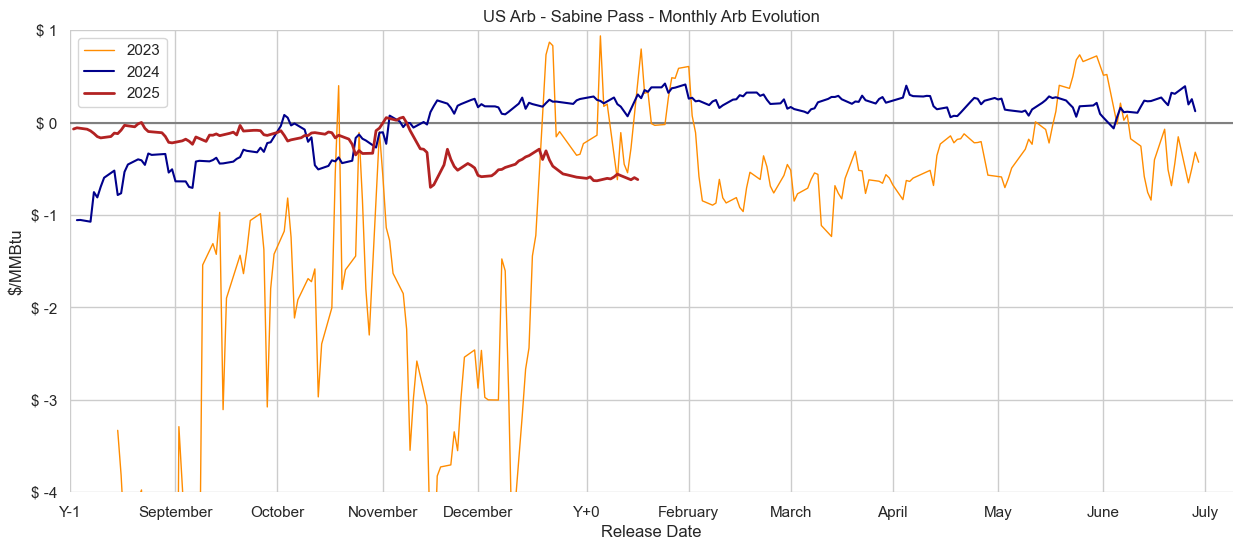

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15,6))

plt.axhline(0, color='grey')

ax.plot(m23['Day of Year'], m23['Delta Outrights'], color='darkorange', label='2023', linewidth=1)
ax.plot(m24['Day of Year'], m24['Delta Outrights'], color='darkblue', label='2024', linewidth=1.5)
ax.plot(m25['Day of Year'], m25['Delta Outrights'], color='firebrick', label='2025', linewidth=2)

plt.ylim(-4,1)

# Setting custom x-axis ticks location and labels.
xlabels = ['Y-1', 'September', 'October', 'November', 'December', 'Y+0', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Year End']

# xpos gives the first day of every other month in terms of 'day of year'
xpos = [-152,-121,-91,-60,-32,0,30,60,90,121,152,182,213,244,274,305,335,365]

plt.xticks(xpos, xlabels)

plt.title('US Arb - ' + df_cogh['FoB Port'].iloc[0] + ' - Monthly Arb Evolution')
plt.ylabel('$/MMBtu')
plt.xlabel('Release Date')

plt.xlim(-152,max([m25["Day of Year"].max(), m24["Day of Year"].max(), m23["Day of Year"].max()])+10)

ax.legend()

sns.despine(left=True, bottom=True)